# Import MNIST and stuff

In [66]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [67]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [68]:
# Look at data a bit
X, y = mnist["data"], mnist["target"] # 784 flattened
y = y.astype(np.uint8)

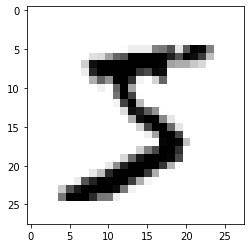

5

In [69]:
# Plot the first digit
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.show()

# Seems like a 5
y[0]
#it was a 5

# Split the data

In [70]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Start with SGD classifier

In [71]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()

# Basic classifying 5s and not-5s
y_train_5 = (y_train==5) 
y_test_5 = (y_test==5)

# Fit
sgd_clf.fit(X_train, y_train_5)

# Predict
sgd_clf.predict([some_digit])

array([ True])

## Score the error


In [72]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, scoring="accuracy")

# It's pretty accurate but even a random model can do that.

array([0.96358333, 0.9665    , 0.95475   , 0.93833333, 0.96258333])

# Better way to see error is with the Confusion matrix

In [73]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

#Negative Class            [TN, FP]
#Positive Class            [FN, TP]

array([[53819,   760],
       [ 1555,  3866]])

## Precision and Recall

- Precision = TP / (TP + FP)
- Recall(TPR) = TP / (TP + FN)


In [74]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_train_5, y_train_pred), "\n")
print(recall_score(y_train_5, y_train_pred), "\n")

0.8357111975789019 

0.7131525548791736 



## Calculate F1 score
- Places more weight on low values of precision and recall.
- The only way to get a good F1 score is to have a high precision and recall

***F1 score is sometimes not usefull because it favors low precision and low recall. But in some cases, we need a high recall but low precision(surveillance classification)***

In [75]:
f1_score(y_train_5, y_train_pred)

0.7695829600875883

# Doing decision threshold stuff
- Increase threshold means decrease in recall but increase in precision(Vice Versa)

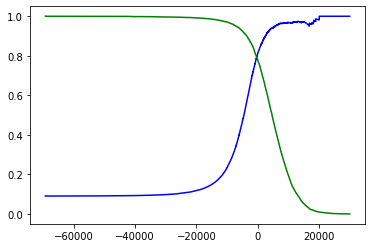

In [76]:
# Get the decision scores for the training data
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
# Use the curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_thresholds(precisions, recall, thresholds):
  plt.plot(thresholds, precisions[:-1], "b", label="Precision"),
  plt.plot(thresholds, recall[:-1], "g", label="Recall")

plot_precision_recall_vs_thresholds(precision, recall, thresholds)
plt.show()

## Get a precision-90 classifier

In [77]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)] # Gets the threshold in which the precision is greater than 0.9
y_train_pred_90 = (y_scores >= threshold_90_precision) # Filters out whichever has a score greater than 90
print(precision_score(y_train_5, y_train_pred_90), "\n")
print(recall_score(y_train_5, y_train_pred_90), "\n")

0.9244272537935139 

0.5731414868105515 



# Plot ROC curve

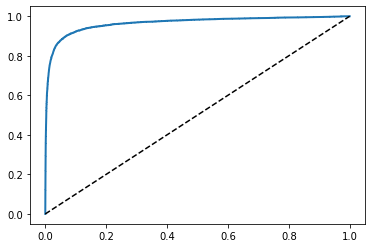

In [78]:
# Get the stuff
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Do the function
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--', )

plot_roc_curve(fpr, tpr)
plt.show()

In [79]:
# AUC
roc_auc_score(y_train_5, y_scores)

0.9647996894502883

## When to use Precision vs Recall graph and when to use ROC and AUC graph

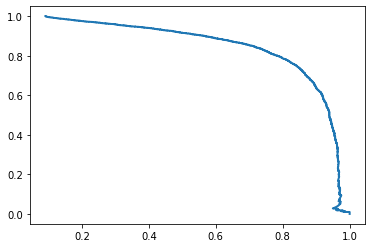

In [80]:
def plot_precision_vs_recall(precisions, recalls, label=None):
  plt.plot(precisions, recalls, linewidth=2, label=label)

plot_precision_vs_recall(precision, recall)
plt.show()

***See how the ROC_AUC_score was really good and this PR graph is real shit(the top right curve should be as close as possible to the top right corner of the box).***


***Use PR curve when the positive class is rare or when you care more about false positives then false negatives.***

# Try different model--Random Forest instead of SGD

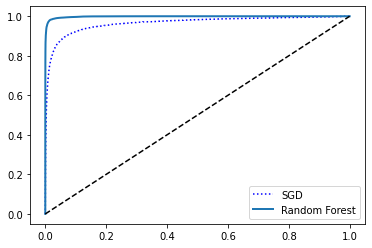

0.9983436731328145

In [87]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42);

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                     method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

#Plot both SGD and forest curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

# As shown the Random Forest is a lot better
roc_auc_score(y_train_5, y_scores_forest)